## Analytic Example 3

In [24]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pyplot as plt
import cvxpy as cp
import time

In [25]:
#Define Jacobian matrix E= dF(0)/dz at origin
E = np.array([[4/3,7/3],[7/6,1/6]])
# compute eigvalues and left eigenvectors of E
e,evecL,evecR = eig(E,left=True)
# eigenvalues
eval1 = e[0].real       # \lambda_2 = 2.5
eval2 = e[1].real       # \lambda_1 = -1
# eigenvectors
w1 = np.sqrt(2) * evecL[:,0]
w2 = np.sqrt(2) * evecL[:,1]
print(eval1)
print(eval2)

2.4999999999999996
-1.0000000000000002


In [26]:
# Define (z_1,z_2) grid
npoints = 30
x_grid = np.linspace(1.5, 2.5, npoints)
y_grid = np.linspace(1.5, 2.5, npoints)

X,Y = np.meshgrid(x_grid,y_grid)
XY = np.zeros((npoints**2,2))

k = 0
for i in range(npoints):
    for j in range(npoints):
        XY[k,:] = np.array([X[i,j],Y[i,j]])
        k = k+1


# Define test grids
n_test = 60
x_grid_test = np.linspace(1.5, 2.5, n_test)
y_grid_test = np.linspace(1.5, 2.5, n_test)

X_test,Y_test = np.meshgrid(x_grid_test,y_grid_test)
XY_test = np.zeros((n_test**2,2))

k = 0
for i in range(n_test):
    for j in range(n_test):
        XY_test[k,:] = np.array([X_test[i,j],Y_test[i,j]])
        k = k+1

In [27]:
#Define functions F and G
def F(x):
    al = 1/(9*x[:,0]**2*x[:,1]**2+6*x[:,0]**2+3*x[:,1]**2+np.cos(x[:,1])+2)
    value1 = (7.5*x[:,1]**2+5)*(x[:,0]**3+x[:,0]+np.sin(x[:,1]))+(-x[:,0]+x[:,1]**3+2*x[:,1])*np.cos(x[:,1])
    value2 = 2.5*x[:,0]**3+2.5*x[:,0]-(3*x[:,0]**2+1)*(-x[:,0]+x[:,1]**3+2*x[:,1])+2.5*np.sin(x[:,1])
    return np.array([al*value1, al*value2]).T

# Define the function g using autograd's numpy (jnp)
def G(x):
    value = np.zeros((len(x),2))
    for i in range(len(x)):
        value[i,:] = np.dot(E, x[i,:])
    value = F(x)-value
    return value

In [28]:
# define eigenfunctions
def phi_2(X):
    return X[:,0] - 2*X[:,1] - X[:,1] ** 3

def phi_1(X):
    return X[:,0] + X[:,0] ** 3 + np.sin(X[:,1])

In [29]:
# copute F and G at mesh grids
F_val = F(XY)
G_val = G(XY)

#### Eigenfunction $\phi_{1}$

In [34]:
# Generate random features
# number of features
N = 100
# scaling parameter
gamma = 0.01
start1 = time.time()
# random feature matrix
Omega = np.random.normal(0, np.sqrt(2*gamma), size=(2,N) )
# random bias
random_bias = np.random.uniform(-np.pi, np.pi, size=(N,))
# temp matrix
A_0 = np.cos(random_bias)
B_0 = np.sin(random_bias)
# generate amtrix A
A = np.zeros((npoints**2+3,N))
A[0,:] = A_0                   # h(0) = 0
A[1:3,:] = B_0 * Omega         # h'(0) = 0
# linear pde
A[3:,:] = - F_val @ Omega * np.sin(XY @ Omega + random_bias) - eval1 * np.cos(XY @ Omega + random_bias) 

# right-hand side
y0 = np.zeros((3,1))
y1 = np.zeros((npoints**2,1))
for i in range(npoints**2):
    y1[i] = -G_val[i,:] @ w1
y = np.row_stack((y0,y1))

# solve optimization problem
c = np.linalg.pinv(A) @ y
end1 = time.time()

In [35]:
# estimate non-linear function h at mesh grids
K = np.cos(XY_test @ Omega + random_bias)
y_test = K@c
# estimate eigenfunction
phi1_hat = y_test.reshape(n_test,n_test) + w1[0] * X_test + w1[1] * Y_test
# compute true eigenfucntion
phi1 = phi_1(XY_test).reshape(n_test,n_test)

# test error
test_error = np.mean( (phi1_hat - phi1) ** 2 )
print(f'Average test error is {test_error:.2e}')

# relative test error
rel_error = np.sum((phi1_hat - phi1) ** 2) / np.sum(phi1**2)
print(f'Relative test error is {rel_error:.2e}')

Average test error is 1.24e-02
Relative test error is 8.56e-05


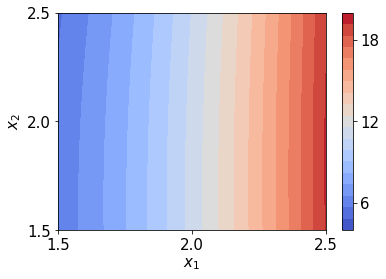

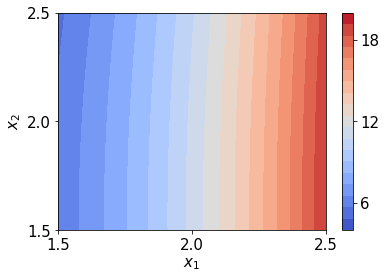

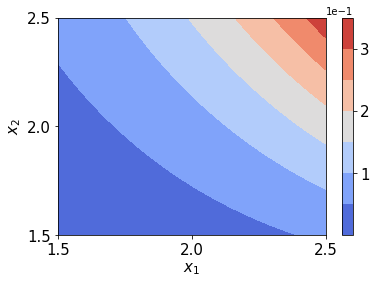

In [36]:
# visualization
plt.figure(1)
im = plt.contourf(X_test,Y_test,phi1_hat, levels=np.linspace(4,20,20),cmap="coolwarm")
cbar = plt.colorbar(im, ticks=[6,12,18])
cbar.ax.tick_params(labelsize=15)
plt.xticks([1.5,2,2.5], fontsize=15)
plt.yticks([1.5,2,2.5], fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig1.pdf', bbox_inches = 'tight')

plt.figure(2)
im = plt.contourf(X_test,Y_test,phi1, levels=np.linspace(4,20,20),cmap="coolwarm")
cbar = plt.colorbar(im, ticks=[6,12,18])
cbar.ax.tick_params(labelsize=15)
plt.xticks([1.5,2,2.5], fontsize=15)
plt.yticks([1.5,2,2.5], fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig1_true.pdf', bbox_inches = 'tight')

plt.figure(3)
im = plt.contourf(X_test,Y_test,abs(phi1 - phi1_hat),cmap="coolwarm")
cbar = plt.colorbar(im,ticks=[0.1,0.2,0.3])
cbar.ax.tick_params(labelsize=15)
cbar.formatter.set_powerlimits((0, 0))
plt.xticks([1.5,2,2.5], fontsize=15)
plt.yticks([1.5,2,2.5], fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig1_error.pdf', bbox_inches = 'tight')

#### Eigenfunction $\phi_{2}$

In [37]:
#Define Jacobian matrix E= dF(0)/dz at origin
E = np.array([[4/3,7/3],[7/6,1/6]])
# compute eigvalues and left eigenvectors of E
e,evecL,evecR = eig(E,left=True)
# eigenvalues
eval1 = e[0].real
eval2 = e[1].real
# eigenvectors
w1 = evecL[:,0]
w2 = -np.sqrt(5) * evecL[:,1]

In [38]:
# Generate random features
# number of features
N = 100
# scaling parameter
gamma = 0.01
# random feature matrix
start2 = time.time()
Omega = np.random.normal(0, np.sqrt(2*gamma), size=(2,N) )
# random bias
random_bias = np.random.uniform(-np.pi, np.pi, size=(N,))
# temp matrix
A_0 = np.cos(random_bias)
B_0 = np.sin(random_bias)
# generate amtrix A
A = np.zeros((npoints**2+3,N))
A[0,:] = A_0                   # h(0) = 0
A[1:3,:] = B_0 * Omega         # h'(0) = 0
# linear pde
A[3:,:] = - F_val @ Omega * np.sin(XY @ Omega + random_bias) - eval2 * np.cos(XY @ Omega + random_bias) 

# right-hand side
y0 = np.zeros((3,1))
y1 = np.zeros((npoints**2,1))
for i in range(npoints**2):
    y1[i] = -G_val[i,:] @ w2
y = np.row_stack((y0,y1))

# solve optimization problem
c = np.linalg.pinv(A) @ y
end2 = time.time()

In [39]:
# estimate non-linear function h at mesh grids
K = np.cos(XY_test @ Omega + random_bias)
y_test = K@c

# estimate eigenfunction
phi2_hat = y_test.reshape(n_test,n_test) + w2[0] * X_test + w2[1] * Y_test
# compute true eigenfucntion
phi2 = phi_2(XY_test).reshape(n_test,n_test)

# test error
test_error = np.mean( (phi2_hat - phi2) ** 2 )
print(f'Average test error is {test_error:.2e}')

# relative test error
rel_error = np.sum((phi2_hat - phi2) ** 2) / np.sum(phi2**2)
print(f'Relative test error is {rel_error:.2e}')

Average test error is 3.92e-07
Relative test error is 3.06e-09


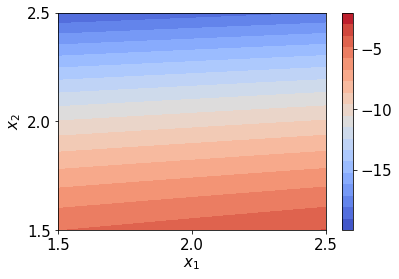

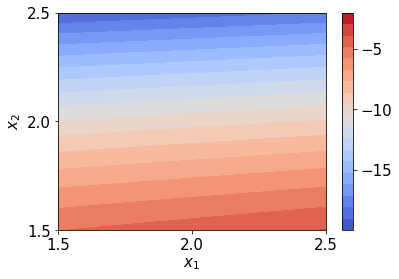

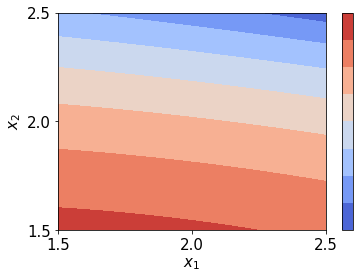

In [41]:
# visualization
plt.figure(1)
im = plt.contourf(X_test,Y_test,phi2_hat,levels=np.linspace(-20,-2,20),cmap="coolwarm")
cbar = plt.colorbar(im, ticks=[-15,-10,-5])
cbar.ax.tick_params(labelsize=15)
plt.xticks([1.5,2,2.5], fontsize=15)
plt.yticks([1.5,2,2.5], fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig2.pdf', bbox_inches = 'tight')

plt.figure(2)
im = plt.contourf(X_test,Y_test,phi2, levels=np.linspace(-20,-2,20),cmap="coolwarm")
cbar = plt.colorbar(im, ticks=[-15,-10,-5])
cbar.ax.tick_params(labelsize=15)
plt.xticks([1.5,2,2.5], fontsize=15)
plt.yticks([1.5,2,2.5], fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig2_true.pdf', bbox_inches = 'tight')

plt.figure(3)
im = plt.contourf(X_test,Y_test,abs(phi2 - phi2_hat),cmap="coolwarm")
cbar = plt.colorbar(im,ticks=[0.0002,0.0003])
cbar.ax.tick_params(labelsize=15)
cbar.formatter.set_powerlimits((0, 0))
plt.xticks([1.5,2,2.5], fontsize=15)
plt.yticks([1.5,2,2.5], fontsize=15)
plt.xlabel(r'$x_1$', fontsize=15)
plt.ylabel(r'$x_2$', fontsize=15)
plt.savefig('eig2_error.pdf', bbox_inches = 'tight')

In [42]:
# computational time
print(f'{end2-start2+end1-start1:.2f} seconds')

0.02 seconds
